In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
!pip install --user numpy==1.19
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [2]:
#data downloaded from yahoo finance, since 8/23/2010
#oxy,occidental petroleum is a good choice because news sentiment impact is minimal compared to popular stocks like tesla
#Also, oxy's stock price is directly correlated with wti crude price
df = pd.read_csv('OXY.csv') 
df_crude = pd.read_csv('CL=F.csv')  #crude oil price data since 8/23/2010,same timeframe as oxy
df.shape,df_crude.shape

((9875, 7), (6298, 7))

In [3]:
#df_crude = df_crude[['Date','Open']]
df_crude = df_crude.dropna()  #remove all nulls 
df_crude.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/23/2000,31.950001,32.799999,31.950001,32.049999,32.049999,79385.0
1,8/24/2000,31.900000,32.240002,31.400000,31.629999,31.629999,72978.0
2,8/25/2000,31.700001,32.099998,31.320000,32.049999,32.049999,44601.0
4,8/28/2000,32.040001,32.919998,31.860001,32.869999,32.869999,46770.0
5,8/29/2000,32.820000,33.029999,32.560001,32.720001,32.720001,49131.0


In [4]:
df.head(15),df_crude.head(15)

(          Date       Open       High        Low      Close  Adj Close  Volume
 0   12/31/1981  11.347040  11.496737  11.197343  11.496737   1.751757  431705
 1     1/4/1982  11.496737  11.556616  11.376979  11.496737   1.751757  329624
 2     1/5/1982  11.376979  11.436858  11.317101  11.317101   1.724385  383274
 3     1/6/1982  11.317101  11.376979  11.257222  11.376979   1.733509  281819
 4     1/7/1982  11.317101  11.376979  11.257222  11.376979   1.733509  168674
 5     1/8/1982  11.556616  11.856010  11.257222  11.257222   1.715262  158027
 6    1/11/1982  11.197343  11.317101  11.017706  11.017706   1.678767  284742
 7    1/12/1982  11.017706  11.077585  10.957827  11.077585   1.687891  242156
 8    1/13/1982  10.957827  11.077585  10.838070  10.957827   1.669644  197482
 9    1/14/1982  10.838070  10.957827  10.718312  10.718312   1.633147  295806
 10   1/15/1982  10.897949  11.017706  10.718312  10.897949   1.660520  204580
 11   1/18/1982  10.897949  10.957827  10.838070  10

In [5]:
df.tail(15),df_crude.tail(15)

(           Date       Open       High        Low      Close  Adj Close  \
 9860   2/9/2021  24.600000  25.150000  24.100000  24.650000  24.650000   
 9861  2/10/2021  24.830000  25.790001  24.799999  25.600000  25.600000   
 9862  2/11/2021  25.400000  25.410000  24.080000  24.980000  24.980000   
 9863  2/12/2021  24.690001  25.750000  24.559999  25.389999  25.389999   
 9864  2/16/2021  26.660000  26.950001  25.879999  26.459999  26.459999   
 9865  2/17/2021  26.840000  27.180000  25.850000  26.730000  26.730000   
 9866  2/18/2021  26.450001  26.730000  25.209999  25.280001  25.280001   
 9867  2/19/2021  25.320000  25.900000  25.030001  25.420000  25.420000   
 9868  2/22/2021  25.990000  27.459999  25.820000  26.469999  26.469999   
 9869  2/23/2021  26.290001  26.650000  24.420000  26.059999  26.059999   
 9870  2/24/2021  26.500000  28.680000  25.959999  28.160000  28.160000   
 9871  2/25/2021  28.170000  28.540001  26.450001  26.750000  26.750000   
 9872  2/26/2021  26.2600

In [6]:
merge=pd.merge(df,df_crude, how='inner', on='Date')#merge two dataframe by same dates
merge.shape

(5117, 13)

In [7]:
merge.head(15)

,Date,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y
0,8/23/2000,10.299160,10.628494,10.299160,10.553645,5.639605,4012060,31.950001,32.799999,31.950001,32.049999,32.049999,79385.0
1,8/24/2000,10.359039,10.388979,10.119524,10.179403,5.439622,1910942,31.900000,32.240002,31.400000,31.629999,31.629999,72978.0
2,8/25/2000,10.209342,10.359039,9.969827,10.269221,5.487617,1096589,31.700001,32.099998,31.320000,32.049999,32.049999,44601.0
3,8/28/2000,10.269221,10.448857,10.149463,10.269221,5.487617,1806774,32.040001,32.919998,31.860001,32.869999,32.869999,46770.0
4,8/29/2000,10.239281,10.299160,10.179403,10.246766,5.475616,1148569,32.820000,33.029999,32.560001,32.720001,32.720001,49131.0
5,8/30/2000,10.119524,10.179403,9.999766,10.112039,5.403621,1910942,32.750000,33.400002,32.099998,33.400002,33.400002,79214.0
6,8/31/2000,10.508736,10.568615,10.269221,10.351554,5.531612,4026882,33.250000,33.700001,32.970001,33.099998,33.099998,56895.0
7,9/1/2000,10.478797,10.778191,10.418918,10.658433,5.695602,2976427,33.049999,33.450001,32.750000,33.380001,33.380001,45869.0
8,9/5/2000,10.778191,10.808130,10.448857,10.748252,5.743600,1664820,33.950001,33.990002,33.419998,33.799999,33.799999,55722.0
9,9/6/2000,10.628494,11.017706,10.628494,10.927888,5.905387,2363105,33.990002,34.950001,33.830002,34.950001,34.950001,74692.0


In [8]:
merge.tail(15)

,Date,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y
5102,2/9/2021,24.600000,25.150000,24.100000,24.650000,24.650000,20757100,58.110001,58.619999,57.270000,58.360001,58.360001,514698.0
5103,2/10/2021,24.830000,25.790001,24.799999,25.600000,25.600000,22400500,58.450001,58.910000,58.080002,58.680000,58.680000,457535.0
5104,2/11/2021,25.400000,25.410000,24.080000,24.980000,24.980000,15221600,58.400002,58.709999,57.840000,58.240002,58.240002,380445.0
5105,2/12/2021,24.690001,25.750000,24.559999,25.389999,25.389999,12361000,57.939999,59.820000,57.410000,59.470001,59.470001,480822.0
5106,2/16/2021,26.660000,26.950001,25.879999,26.459999,26.459999,19260400,59.980000,60.950001,59.330002,60.049999,60.049999,602332.0
5107,2/17/2021,26.840000,27.180000,25.850000,26.730000,26.730000,15082100,60.240002,61.730000,59.430000,61.139999,61.139999,335419.0
5108,2/18/2021,26.450001,26.730000,25.209999,25.280001,25.280001,15311700,61.680000,62.259998,59.790001,60.520000,60.520000,132035.0
5109,2/19/2021,25.320000,25.900000,25.030001,25.420000,25.420000,14936100,60.200001,60.290001,58.590000,59.240002,59.240002,102427.0
5110,2/22/2021,25.990000,27.459999,25.820000,26.469999,26.469999,22820600,58.880001,61.840000,58.820000,61.490002,61.490002,505773.0
5111,2/23/2021,26.290001,26.650000,24.420000,26.059999,26.059999,22587700,62.160000,63.000000,60.669998,61.669998,61.669998,570677.0


In [9]:
merge.dtypes

Date            object
Open_x         float64
High_x         float64
Low_x          float64
Close_x        float64
Adj Close_x    float64
Volume_x         int64
Open_y         float64
High_y         float64
Low_y          float64
Close_y        float64
Adj Close_y    float64
Volume_y       float64
dtype: object

In [10]:
merge.isnull().sum()  #no null values in dataframe

Date           0
Open_x         0
High_x         0
Low_x          0
Close_x        0
Adj Close_x    0
Volume_x       0
Open_y         0
High_y         0
Low_y          0
Close_y        0
Adj Close_y    0
Volume_y       0
dtype: int64

In [11]:
merge.info() #confirm with no nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5117 entries, 0 to 5116
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5117 non-null   object 
 1   Open_x       5117 non-null   float64
 2   High_x       5117 non-null   float64
 3   Low_x        5117 non-null   float64
 4   Close_x      5117 non-null   float64
 5   Adj Close_x  5117 non-null   float64
 6   Volume_x     5117 non-null   int64  
 7   Open_y       5117 non-null   float64
 8   High_y       5117 non-null   float64
 9   Low_y        5117 non-null   float64
 10  Close_y      5117 non-null   float64
 11  Adj Close_y  5117 non-null   float64
 12  Volume_y     5117 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 559.7+ KB


In [12]:
#select all necessary columns and rename columns
df = merge[['Open_x','High_x','Low_x','Close_x','Adj Close_x','Volume_x','Open_y']]
df = df.rename({'Open_x': 'open', 'High_x': 'high','Low_x':'low','Close_x':'close',\
                 'Adj Close_x':'adj_close','Volume_x':'volume','Open_y':'crude_price'}, axis=1)


In [13]:
df.head()

,open,high,low,close,adj_close,volume,crude_price
0,10.299160,10.628494,10.299160,10.553645,5.639605,4012060,31.950001
1,10.359039,10.388979,10.119524,10.179403,5.439622,1910942,31.900000
2,10.209342,10.359039,9.969827,10.269221,5.487617,1096589,31.700001
3,10.269221,10.448857,10.149463,10.269221,5.487617,1806774,32.040001
4,10.239281,10.299160,10.179403,10.246766,5.475616,1148569,32.820000


In [14]:
df.tail()

,open,high,low,close,adj_close,volume,crude_price
5112,26.500000,28.680000,25.959999,28.160000,28.160000,27789000,61.290001
5113,28.170000,28.540001,26.450001,26.750000,26.750000,21142500,63.389999
5114,26.260000,27.010000,25.209999,26.610001,26.610001,21615400,63.459999
5115,27.370001,28.280001,27.010000,27.639999,27.639999,15865000,61.950001
5116,27.590000,28.510000,27.320000,27.820000,27.820000,16531500,60.230000


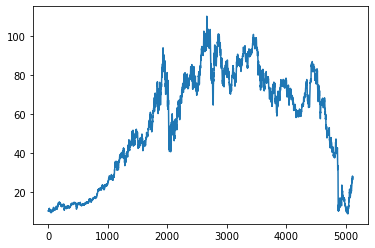

In [15]:
plt.plot(df['open']) #stock price chart


In [16]:
#scale data from 0 to 1
#scaled data using standard deviation and mean results in some negative values. 

scaler=MinMaxScaler()
train_set_scaled=scaler.fit_transform(df)





 

In [17]:
train_set_scaled

array([[0.01574248, 0.01414927, 0.01765466, ..., 0.00872009, 0.02436213,
        0.28864879],
       [0.01633195, 0.01184149, 0.01587213, ..., 0.00592573, 0.00825566,
        0.28833469],
       [0.0148583 , 0.01155301, 0.01438668, ..., 0.00659637, 0.0020131 ,
        0.28707834],
       ...,
       [0.17286451, 0.17198874, 0.1656154 , ..., 0.30173909, 0.15930344,
        0.48658834],
       [0.1837916 , 0.18422549, 0.18347687, ..., 0.31613124, 0.1152228 ,
        0.47710283],
       [0.18595732, 0.18644158, 0.18655301, ..., 0.31864639, 0.12033196,
        0.46629813]])

In [18]:
#use x_1,x_2,..., x_i as vectors of independent variables to predict the future stock price, x_(i+1)
#i is the time_step
def create_dataset(dataset,time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),1:dataset.shape[1]] 
        dataX.append(a) #list of stocks for independent variables
        dataY.append(dataset[i+time_step,0]) #dependent variable
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 30 #this parameter can be tuned, can be think of as "30 day moving average"
               #lSTM, long short term memory can handle up to 100 steps backward. 

#split to test and train set, note here cross validation with n-fold will not work in this case since data is ordered by date
training_size = int(len(train_set_scaled)*0.70) #train_test_split libary will not work because of ordering
test_size = len(train_set_scaled) - training_size
train_set,test_set = train_set_scaled[0:training_size,:],train_set_scaled[training_size:len(train_set_scaled),:]
X_train, y_train = create_dataset(train_set, time_step)
X_test, y_test = create_dataset(test_set, time_step)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3550, 30, 6), (3550, 1), (1505, 30, 6), (1505, 1))

In [20]:
X_train, X_test

(array([[[0.01414927, 0.01765466, 0.01640731, 0.00872009, 0.02436213,
          0.28864879],
         [0.01184149, 0.01587213, 0.01273849, 0.00592573, 0.00825566,
          0.28833469],
         [0.01155301, 0.01438668, 0.01361901, 0.00659637, 0.0020131 ,
          0.28707834],
         ...,
         [0.01386079, 0.01884302, 0.01684757, 0.00994709, 0.02249944,
          0.28550789],
         [0.01559163, 0.01943721, 0.01714108, 0.01017321, 0.01743306,
          0.28896287],
         [0.01443774, 0.01498085, 0.01185797, 0.00610389, 0.01722344,
          0.28645015]],
 
        [[0.01184149, 0.01587213, 0.01273849, 0.00592573, 0.00825566,
          0.28833469],
         [0.01155301, 0.01438668, 0.01361901, 0.00659637, 0.0020131 ,
          0.28707834],
         [0.01241843, 0.01616921, 0.01361901, 0.00659637, 0.00745714,
          0.28921415],
         ...,
         [0.01559163, 0.01943721, 0.01714108, 0.01017321, 0.01743306,
          0.28896287],
         [0.01443774, 0.01498085, 0.011

In [21]:
y_train, y_test

(array([[0.01426883],
        [0.01220572],
        [0.01043734],
        ...,
        [0.7067454 ],
        [0.70065239],
        [0.69446107]]), array([[0.70861267],
        [0.69436276],
        [0.7052713 ],
        ...,
        [0.19166697],
        [0.17286451],
        [0.1837916 ]]))

In [22]:
#LSTM model requires the input to be the shape of (sampes, times_step, features)
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((3550, 30, 6), (3550, 1), (1505, 30, 6), (1505, 1))

In [23]:
#run stacked LSTM model, Long Short-Term Memory Networks
model = Sequential()
model.add(LSTM(units=64,return_sequences=True,input_shape=(time_step,X_train.shape[2])))
model.add(LSTM(units=10,return_sequences=False))
model.add(Dropout(0.25))#use to avoid overfit
model.add(Dense(units=1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy']) #adam uses stochastic gradient descent 

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                3000      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 21,187
Trainable params: 21,187
Non-trainable params: 0
_________________________________________________________________


In [25]:
#train model,open price is the dependent variable and all other features are independent variables
history = model.fit(X_train,y_train,validation_data=(X_train,y_train),epochs=100,batch_size=256,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 197ms/step - loss: 0.0719 - accuracy: 2.8169e-04 - val_loss: 0.0074 - val_accuracy: 2.8169e-04
Epoch 2/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0218 - accuracy: 2.8169e-04 - val_loss: 0.0022 - val_accuracy: 2.8169e-04
Epoch 3/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0156 - accuracy: 2.8169e-04 - val_loss: 0.0028 - val_accuracy: 2.8169e-04
Epoch 4/100
14/14 [==============================] - 1s 63ms/step - loss: 0.0136 - accuracy: 2.8169e-04 - val_loss: 8.0380e-04 - val_accuracy: 2.8169e-04
Epoch 5/100
14/14 [==============================] - 1s 61ms/step - loss: 0.0129 - accuracy: 2.8169e-04 - val_loss: 7.5288e-04 - val_accuracy: 2.8169e-04
Epoch 6/100
14/14 [==============================] - 1s 59ms/step - loss: 0.0121 - accuracy: 2.8169e-04 - val_loss: 0.0012 - val_accuracy: 2.8169e-04
Epoch 7/100
14/14 [==============================] - 1s 60ms/step - loss: 0.0121 - accuracy

14/14 [==============================] - 1s 57ms/step - loss: 0.0054 - accuracy: 2.8169e-04 - val_loss: 4.9476e-04 - val_accuracy: 2.8169e-04
Epoch 55/100
14/14 [==============================] - 1s 57ms/step - loss: 0.0048 - accuracy: 2.8169e-04 - val_loss: 4.5443e-04 - val_accuracy: 2.8169e-04
Epoch 56/100
14/14 [==============================] - 1s 59ms/step - loss: 0.0050 - accuracy: 2.8169e-04 - val_loss: 5.9530e-04 - val_accuracy: 2.8169e-04
Epoch 57/100
14/14 [==============================] - 1s 61ms/step - loss: 0.0050 - accuracy: 2.8169e-04 - val_loss: 5.6836e-04 - val_accuracy: 2.8169e-04
Epoch 58/100
14/14 [==============================] - 1s 62ms/step - loss: 0.0049 - accuracy: 2.8169e-04 - val_loss: 0.0010 - val_accuracy: 2.8169e-04
Epoch 59/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0051 - accuracy: 2.8169e-04 - val_loss: 6.2488e-04 - val_accuracy: 2.8169e-04
Epoch 60/100
14/14 [==============================] - 1s 60ms/step - loss: 0.0050 - acc

In [26]:
score = model.evaluate(X_test,y_test)
score

48/48 [==============================] - 0s 6ms/step - loss: 4.8370e-04 - accuracy: 6.6445e-04


[0.0004836983571294695, 0.0006644517998211086]

In [27]:
tf.__version__

'2.3.1'

In [28]:
#do prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape, y_train.shape

((3550, 1), (3550, 1))

In [29]:
#change to original scale to check performance
X_train = X_train[:,0,:]
print(X_train.shape)
X_train_predict = np.concatenate((train_predict, X_train),axis=1)
train_predict = scaler.inverse_transform(X_train_predict)
train_predict = train_predict[:,0]
train_predict

(3550, 6)


array([13.09659789, 13.0471091 , 12.98604658, ..., 79.03584225,
       79.39629575, 79.57086734])

In [30]:
X_test = X_test[:,0,:]
X_test_predict = np.concatenate((test_predict, X_test),axis=1)
test_predict = scaler.inverse_transform(X_test_predict)
test_predict = test_predict[:,0]
test_predict

array([80.06688749, 79.87383065, 79.62005036, ..., 27.68895543,
       27.81165112, 27.89482571])

In [31]:
#inverse y_train to get original stock price
X_train = np.concatenate((y_train, X_train),axis=1)
y_train = scaler.inverse_transform(X_train)
y_train = y_train[:,0]

In [32]:
#inverse y_test to get original stock price
X_test= np.concatenate((y_test, X_test),axis=1)
y_test = scaler.inverse_transform(X_test)
y_test = y_test[:,0]
y_test

array([80.68261 , 79.235069, 80.343185, ..., 28.17    , 26.26    ,
       27.370001])

In [33]:
train_predict, y_train

(array([13.09659789, 13.0471091 , 12.98604658, ..., 79.03584225,
        79.39629575, 79.57086734]),
 array([10.149463,  9.939887,  9.760251, ..., 80.492928, 79.873985,
        79.245056]))

In [34]:
#compute performance metrics using MSE
math.sqrt(mean_squared_error(y_train,train_predict))

2.7551651254225895

In [35]:
test_predict, y_test

(array([80.06688749, 79.87383065, 79.62005036, ..., 27.68895543,
        27.81165112, 27.89482571]),
 array([80.68261 , 79.235069, 80.343185, ..., 28.17    , 26.26    ,
        27.370001]))

In [36]:
math.sqrt(mean_squared_error(y_test,test_predict))

2.234117366474433

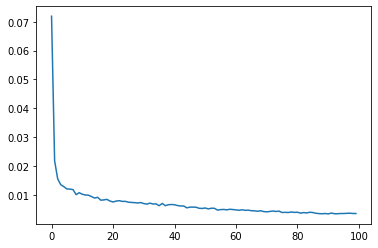

In [37]:
plt.plot(history.history['loss'])
plt.show()

In [38]:
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)
train_predict.shape, test_predict.shape

((3550, 1), (1505, 1))

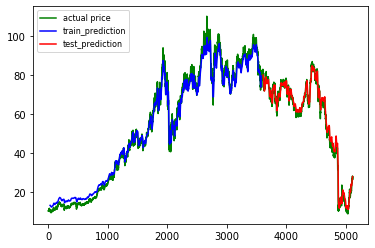

In [39]:
#visualization
# shift train predictions for plotting
look_back = 30
trainPredictPlot = np.empty_like(df[['open']])
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df[['open']])
testPredictPlot[:,:] =np.nan
testPredictPlot[len(train_predict)+look_back*2+1:len(df[['open']])-1,:] = test_predict
# put it together
plt.plot(df[['open']],color='green',label='actual price')
plt.plot(trainPredictPlot,color='blue', label='train_prediction')
plt.plot(testPredictPlot,color='red',label='test_prediction')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [40]:
#use this model to predict future 1 days!
#Unfortunately, this model will not able to predict more than one day into the future
#since this multivariate model only produces the only one outcome, open price
#and features such as low, high, volume, crude_price,adj_close are not available. 
len(test_set)

1536

In [41]:
test_set.shape

(1536, 7)

In [42]:
X_input = test_set[1506:,:]
X_input.shape

(30, 7)

In [43]:
X_input = X_input.reshape(1,30,7)
y_predict = model.predict(X_input)
y_predict

ValueError: in user code:

    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\zcj10\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 6), found shape=[None, 30, 7]


In [ ]:
X_input = X_input[:,0,1:]
X_input= np.concatenate((y_predict, X_input),axis=1)
y_pred = scaler.inverse_transform(X_input)
y_pred = y_pred[:,0]
y_pred     #this is the prediction for oxy on 1/14/2020, looks good!
           #the close price for oxy on 1/13/2020 is 22.33. 
           #multiple runs show results ranging from 18 to 23 dollars. 

Further research: Compare this model with Stochastic Geometric Brownian Motion model. 